In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorcet as cc
import os

### Read embeddings

In [25]:
rna_embs_path = r"C:\Users\Amir Ebrahimi\sc-cool\results\SHARE\scCOOL\embs\rna_emb0.npy"
atac_embs_path = r"C:\Users\Amir Ebrahimi\sc-cool\results\SHARE\scCOOL\embs\atac_emb0.npy"
lbls_path = r"C:\Users\Amir Ebrahimi\sc-cool\results\SHARE\scCOOL\embs\test_cell_types_0.npy"

In [26]:
rna_embs = np.load(rna_embs_path)
atac_embs = np.load(atac_embs_path)
lbls = np.load(lbls_path)

print(rna_embs.shape)
print(atac_embs.shape)
print(lbls.shape)

(9670, 128)
(9670, 128)
(9670,)


In [27]:
lbls

array(['Basal', 'Infundibulum', 'TAC-1', ..., 'ahigh CD34+ bulge',
       'TAC-1', 'alow CD34+ bulge'], dtype='<U25')

In [29]:
df = pd.read_csv(r"C:\Users\Amir Ebrahimi\sc-cool\results\SHARE\scCOOL\Metrics_scCOOL.csv")
df.head()

,Models,Replicates,k,Recall_at_k,Num_pairs,Class_label_acc
0,scCOOL,1,10,0.034436,40.0,0.661013
1,scCOOL,1,20,0.061013,40.0,0.661013
2,scCOOL,1,30,0.088831,40.0,0.661013
3,scCOOL,1,40,0.111789,40.0,0.661013
4,scCOOL,1,50,0.132989,40.0,0.661013


In [30]:
save_dir = r"C:\Users\Amir Ebrahimi\sc-cool\results\SHARE\scCOOL"
model_name = "scCOOL" 

In [7]:
def plot_recall_at_k(data:pd.DataFrame, save_dir:str, model_name:str) -> None:

    """
    Plot Recall@k value for each model at different k neighbor embeddings.

    Parameters
    ----------
    data: pandas.DataFrame
        A data frame containing Recall@k values.

    save_dir: str
        Path to save plots.

    model_name: str
        Name of the model to be include the file name.

    Return
    ----------
    None
    
    """

    model_colors = {
        "Ours": "#1f77b4",  
        "Con-AAE": "#ff7f0e", 
        "Harmony": "#2ca02c",  
        "MOFA": "#d62728",  
        "AE": "#9467bd", 
    }


    grouped_data = data.groupby(['Models', 'Replicates'])['Class_label_acc'].agg(['mean', 'std']).reset_index()

    plt.figure(figsize=(12, 8))

    for model in grouped_data['Models'].unique():
        
        model_data = grouped_data[grouped_data['Models'] == model]
        plt.errorbar(
            model_data['Replicates'], model_data['mean'], yerr=model_data['std'],
            fmt='-o', label=model, capsize=5, capthick=1, linewidth=2,
            color=model_colors[model]
        )

    plt.title('Cell Type Accuracy After Reverse Modality Prediction', fontsize=16)
    plt.xlabel('k', fontsize=14)
    plt.ylabel('Cell Type Accuracy', fontsize=14)
    plt.legend(title='Model', fontsize=12, title_fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks([10, 20, 30, 40, 50], fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(save_dir + "\\cell_type_acc" + model_name + ".png")


<Figure size 800x400 with 0 Axes>

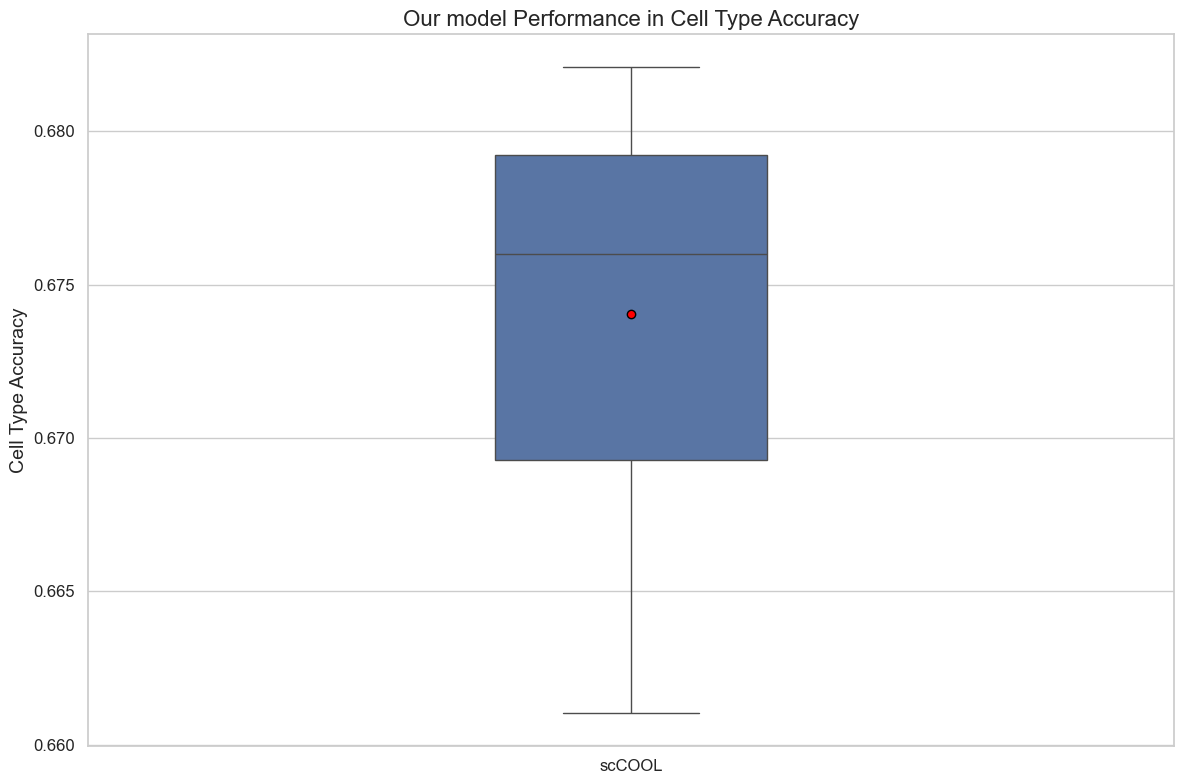

In [31]:
plt.figure(figsize=(8, 4))
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x="Models", y="Class_label_acc", data=df, 
                 showmeans=True, meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"},
                width=0.25)
ax.set_xlabel('')
plt.title("Our model Performance in Cell Type Accuracy", fontsize=16)
plt.ylabel("Cell Type Accuracy", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(save_dir + "\\cell_type_acc_" + model_name + ".png")

plt.show()

## UMAP 

In [20]:
save_path = r"C:\Users\Amir Ebrahimi\sc-cool\results\PBMC\scCOOL\embs"

### Compute joint embeddings

In [30]:

joint_embs = np.hstack((rna_embs, atac_embs))

print(rna_embs.shape)
print(atac_embs.shape)
print(lbls.shape)
print(joint_embs.shape)

(9670, 128)
(9670, 128)
(9670,)
(9670, 256)


In [72]:
#reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean')
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='cosine')

In [73]:
umap_embs = reducer.fit_transform(joint_embs)
print(umap_embs.shape)

(27079, 2)


In [7]:
cell_types = np.unique(lbls)
colors = colors = cc.glasbey[:len(cell_types)]

for i, cell_type in enumerate(cell_types):
    mask = lbls == cell_type
    plt.scatter(umap_embs[mask, 0], umap_embs[mask, 1], 
                s=5, label=f" {cell_type}", color=colors[i])

plt.title("UMAP Visualization Colored by Cell Types - CITE-seq Joint Embeddings")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Cell Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
#plt.savefig(save_path + "/" + "")

NameError: name 'umap_embs' is not defined

## t-SNE

In [5]:
from sklearn.manifold import TSNE

In [31]:
tsne_embs = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(joint_embs)

print(tsne_embs.shape)

(9670, 2)


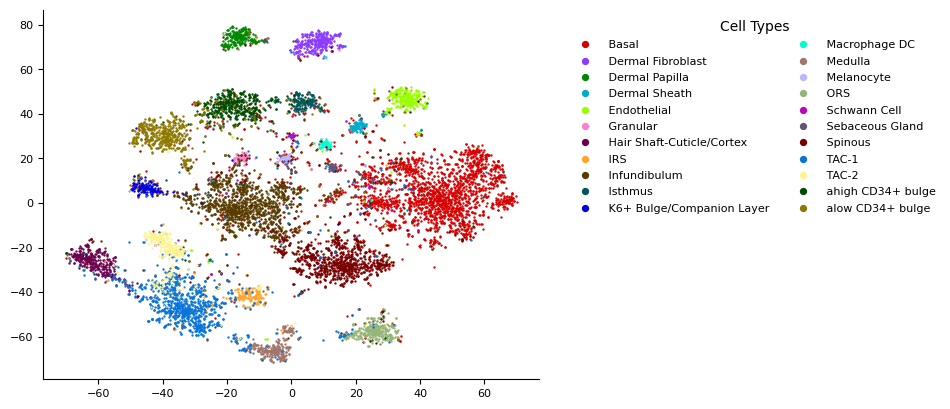

In [32]:
cell_types = np.unique(lbls)
colors = cc.glasbey[:len(cell_types)]

for i, cell_type in enumerate(cell_types):
    mask = lbls == cell_type
    plt.scatter(tsne_embs[mask, 0], tsne_embs[mask, 1], 
                s=0.5, label=f" {cell_type}", color=colors[i])

plt.tick_params(axis='both', which='major', labelsize=8)

ax = plt.gca()  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.legend(
    title="Cell Types", 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left',
    fontsize=8, 
    ncol=2, 
    frameon=False,
    handleheight=1,  # Adjust spacing between markers
    markerscale=6    # Adjust size of legend markers
)

plt.show()

## Test ASW original

In [3]:
path = "/Users/amirebrahimi/sc-cool/results/Ours_PCA_Mod1_Mod2_ASW.csv"
res_df = pd.read_csv(path)
print(res_df)

    Data   PCA_ASW  Mod1_ASW  Mod2_ASW  Our_ASW
0  SHARE  0.408505  0.408007  0.437531   0.6126
1   PBMC  0.503428  0.485125  0.493272   0.7021
2   CITE  0.196942  0.189315  0.263780   0.5101


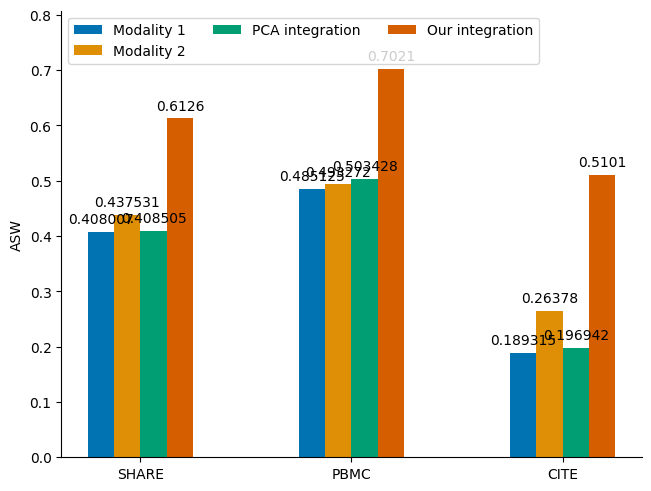

In [5]:
data_lbls = ["SHARE", "PBMC", "CITE"]
mod_lbls = {
    "Modality 1": tuple(res_df["Mod1_ASW"].values),
    "Modality 2": tuple(res_df["Mod2_ASW"].values),
    "PCA integration": tuple(res_df["PCA_ASW"].values),
    "Our integration": tuple(res_df["Our_ASW"].values)
}

group_spacing = 1  # Change this to control the spacing
x = np.arange(len(data_lbls)) * (1 + group_spacing)
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
colors = sns.color_palette("colorblind", len(mod_lbls))

for (attribute, measurement), color in zip(mod_lbls.items(), colors):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=color)
    
    # Adjust label position with padding
    ax.bar_label(rects, padding=4, label_type='edge')
    multiplier += 1

max_asw = max(max(res_df["Mod1_ASW"]), max(res_df["Mod2_ASW"]),
              max(res_df["PCA_ASW"]), max(res_df["Our_ASW"]))

# Increase y-limit for better spacing
ax.set_ylim(0, max_asw + 0.15 * max_asw)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('ASW')
ax.set_xticks(x + width * (len(mod_lbls) - 1) / 2)
ax.set_xticklabels(data_lbls)
ax.legend(loc='upper left', ncols=3)
plt.show()
